<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Soma_Size/Cell_pose_JB_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [196]:
!pip install scikit-image --quiet
!pip install matplotlib --quiet
!pip install pandas --quiet
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet
!pip install cellpose --quiet

In [197]:
import matplotlib
import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
from tqdm import tqdm
import scipy as sci
from cellpose import models

In [198]:
def plot_point_data_pcol(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None,cmap='viridis'):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x]
        x=rad
        y=rad

    xy_slice = image_stack[z,:,:]
    zy_slice = image_stack[:,:,x].transpose([1,0])
    zx_slice = image_stack[:,y,:]

    vmin = np.percentile(image_stack,.1)
    vmax = np.percentile(image_stack,99.9)
    print(vmin,vmax)

    fig,ax=plt.subplots(2,3,width_ratios=[5, 1, .5],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax=ax.flatten()
    # ,aspect='auto'
    cbh=ax[0].pcolorfast(xy_slice,zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])
    ax[0].invert_yaxis()

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[3].imshow(zx_slice,aspect='auto',zorder=-1, vmin=vmin, vmax=vmax, cmap=cmap) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[3].axvline(x,color='m',linewidth=lw)
    ax[3].axhline(z,color='y',linewidth=lw)

    plt.colorbar(cbh,cax=ax[2])

    for a in ax[4:]:
        a.axis('off')
    plt.tight_layout()
    return fig,ax,cbh

In [199]:
def plot_point_data_rgb(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),rad=None):
    """ Assume 'zxyc' format"""

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[1]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[2]])
        image_stack = image_stack[:,min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    print(image_stack.shape,x,y)

    xy_slice = image_stack[z,:,:,:]
    zy_slice = image_stack[:,:,x,:].transpose([1,0,2])
    zx_slice = image_stack[:,y,:,:]


    z_ratio = image_stack.shape[0]/image_stack.shape[1]

    fig,ax=plt.subplots(2,2,width_ratios=[1, z_ratio],height_ratios=(1,z_ratio),figsize=figsize,dpi=300)
    ax=ax.flatten()

    ax[0].imshow(xy_slice,aspect='auto',zorder=-1) # vmin=vmin,vmax=vmax,cmap=cmap,
    ax[0].axvline(x,color='m',linewidth=lw)
    ax[0].axhline(y,color='c',linewidth=lw)
    ax[0].set_xticks([])

    ax[1].imshow(zy_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[1].axhline(y,color='c',linewidth=lw)
    ax[1].axvline(z,color='y',linewidth=lw)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    ax[2].imshow(zx_slice,aspect='auto',zorder=-1) # ,vmin=vmin,vmax=vmax,cmap=cmap,
    ax[2].axvline(x,color='m',linewidth=lw)
    ax[2].axhline(z,color='y',linewidth=lw)




    ax[3].axis('off')
    plt.tight_layout()
    return fig,ax



def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    data_t =data_t.astype('float16')
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def norm_channels(im_data,tiff_format,clip=False):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),[99,1])
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

def med_filt_stack(img,d):
    color_dim = tiff_format.index('c')
    z_dim = tiff_format.index('z')
    color_dim=1
    z_dim=0
    for c in range(img.shape[color_dim]):
        for z in range(img.shape[z_dim]):
            img[z,c,:,:] = ski.filters.median(img[z,c,:,:],footprint=np.ones([d,d]))
    return img


In [200]:

"""On Site"""
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/'
"""Off Site"""
source_directory = 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF'

os.chdir(source_directory)
my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))
print(my_tiffs)
curr_tif = my_tiffs[0]

['C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-E_20x2_1.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-E_20x2_2.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-F_20x2_1.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-F_20x2_2.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-G_20x2_1.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-G_20x2_2.tif', 'C:\\Users\\denni\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\NeuN_5-10mo\\TIFF\\DAPI-NeuN_E3-H_20x2_1.tif', 'C:\\Users\\denni\\Dropbox

In [201]:
tiff_format = 'zcyx'
color_format = 'RB'
rbg_channel_order = [1,0,0]

In [202]:
tiff_data_raw = tifffile.imread(curr_tif)
tiff_data = tiff_data_raw.copy()
tiff_format = 'zcyx'
print(tiff_data.shape)

tiff_data = ski.filters.gaussian(tiff_data, sigma=[1,1,1],mode='reflect',truncate = 4,channel_axis=1)
tiff_data = med_filt_stack(tiff_data,5)
print(tiff_data.shape)
tiff_data = norm_channels(tiff_data,'zcyx',clip=True)
tiff_data = tiff_data[:,rbg_channel_order,:,:]
print(tiff_data.shape)
tiff_data[:,1,:,:]=0


(29, 2, 800, 800)
(29, 2, 800, 800)
(29, 3, 800, 800)


In [203]:
rgb_stack = tiff_data.transpose(0,2,3,1)*225
rgb_stack[rgb_stack<0]=0
rgb_stack[rgb_stack>255]=255
rgb_stack=rgb_stack.astype('uint8')

# _=plot_point_data_rgb(400,600,20,rgb_stack,figsize=(3,2.7)) #,rad=50


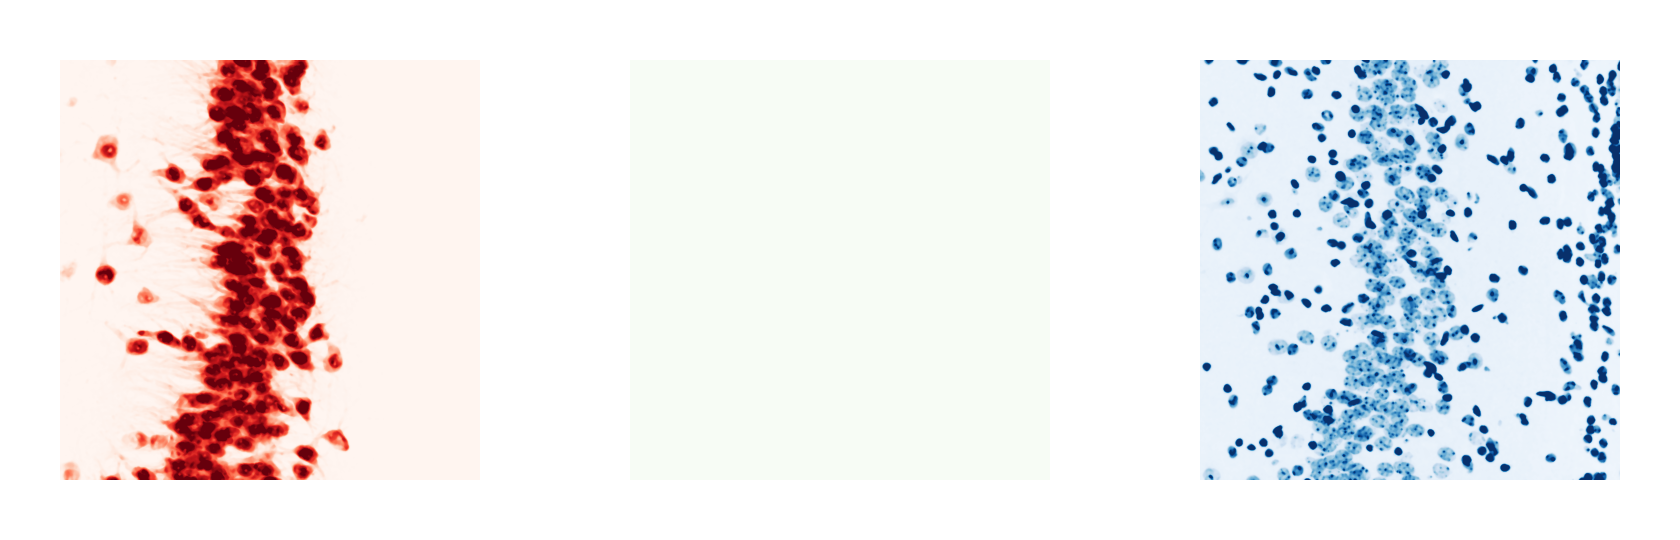

In [204]:
""" Display Split Projections """
num_c = tiff_data.shape[1]
fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=600)
colors = ['Reds','Greens','Blues','gray']
for c in range(num_c):
    ax[c].imshow(np.max(tiff_data[:,c,:,:],axis=0), cmap=colors[c],vmin=0,vmax=1)
    ax[c].axis('off')
plt.tight_layout()

In [205]:
# colors = ['Reds','Greens','Blues','gray_r']
# for z in range(tiff_data.shape[0]):
#     num_c = tiff_data.shape[1]
#     fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
#     for c in range(num_c):
#         ax[c].imshow(tiff_data[z,c], cmap=colors[c],vmin=0,vmax=1)
#         ax[c].axis('off')
#     plt.tight_layout()
#     plt.show()

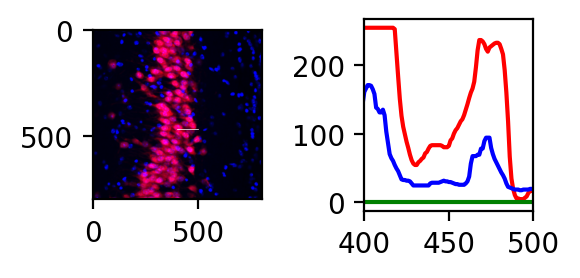

In [206]:
z_show = 13

img_rgb = tiff_data.transpose([0,2,3,1])*255
img_rgb[img_rgb>255]=255
img_rgb[img_rgb<0]=0
img_rgb=img_rgb.astype('uint8')
fig,ax =plt.subplots(1,2,figsize=(3,1.5),dpi=200)
ax[0].imshow(img_rgb[z_show])
y=465
xb=np.cumsum([400,100])
ax[0].plot(xb,[y,y],'w',linewidth=.25)
ax[1].plot(img_rgb[z_show,y,:,0],color='r')
ax[1].plot(img_rgb[z_show,y,:,1],color='g')
ax[1].plot(img_rgb[z_show,y,:,2],color='b')
ax[1].set_xlim(xb)
plt.tight_layout()

In [207]:
zi = 35
cell_diam = 30
nuc_diam = None
cell_channel = 0
nuclear_channel = 3
channel_axis = 3

image is not 2D cannot compute diameter
100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 153.01it/s]


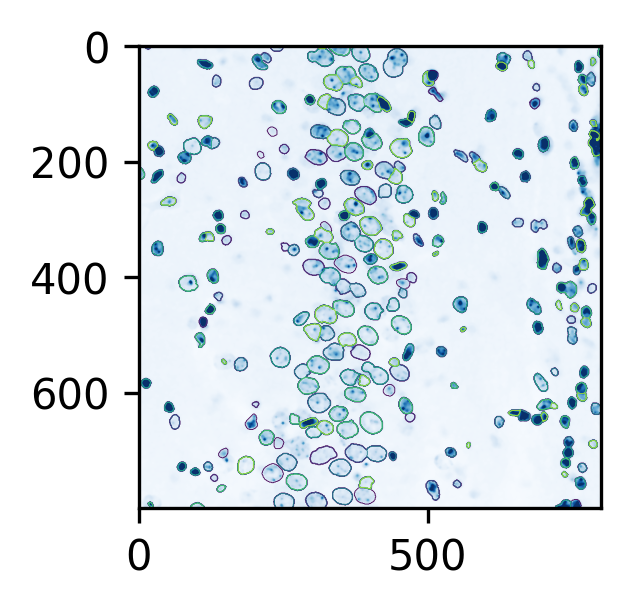

In [208]:
""" Define Nuclear Model """
nuclear_model = models.Cellpose(model_type='nuclei',gpu=True)
(nuclear_masks, _, _, _) =  nuclear_model.eval(img_rgb, channels=[nuclear_channel, 0], channel_axis = channel_axis, diameter=nuc_diam, do_3D=False, stitch_threshold=0.02,) # ,stitch_threshold=0.02

fig,ax=plt.subplots(1,figsize=(2,2),dpi=300)
plt.imshow(img_rgb[20,:,:,2],cmap='Blues')
plt.contour(nuclear_masks[20,:,:],linewidths=.2)


In [57]:
""" Define Cell Model """
cell_diam=40
cell_model = models.Cellpose(model_type='cyto3',gpu=True)
cell_channel = 1
nuclear_channel = 0
print('nuclear_channel',nuclear_channel)
print('cell_channel',cell_channel)
(cell_masks, flows, styles, diams) =  cell_model.eval(img_rgb, channels=[cell_channel,nuclear_channel], channel_axis = channel_axis, diameter=cell_diam, do_3D=False, stitch_threshold=0.02,) # ,stitch_threshold=0.02, diameter=diam,
fig,ax=plt.subplots(1,figsize=(3,3),dpi=300)
plt.imshow(np.sum(cell_masks>0,axis=0))

nuclear_channel 0
cell_channel 1


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 172.84it/s]


In [ ]:
""" Display Split Projections """
num_c = tiff_data.shape[1]
fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=600)
colors = ['Reds','Greens','Blues','gray']
for c in range(num_c):
    ax[c].imshow(np.max(tiff_data[:,c,:,:],axis=0), cmap=colors[c],vmin=0,vmax=1)
    ax[c].axis('off')
plt.tight_layout()

In [60]:
def no_edges(masks):
    masks_og = masks.copy()
    planes = [masks[0,:,:],
              masks[-1,:,:],
              masks[:,0,:],
              masks[:,-1,:],
              masks[:,:,0],
              masks[:,:,-1]]

    for p in planes:
        del_ids = np.unique(p)
        for id in del_ids:
            masks[masks==id] = 0
    return masks, masks_og

cell_masks, cell_masks_og = no_edges(cell_masks)

In [193]:
nuc_ids = np.unique(nuclear_masks)
cell_ids = np.unique(cell_masks)
nuc_ids = nuc_ids[nuc_ids>0]
cell_ids = cell_ids[cell_ids>0]
sizes, edges = np.histogram(cell_masks.flatten(),bins=np.concatenate([cell_ids,[np.max(cell_ids+1)]]))
cell_df = pd.DataFrame({'cell_ids':cell_ids,'nuc_ids':[list()]*len(cell_ids),'size_vxl':sizes}).set_index('cell_ids')
for c in cell_df.index:
    nucs = nuclear_masks[cell_masks==c]
    nucs = nucs[nucs>0]
    cell_df.at[c,'nuc_ids']=np.unique(nucs)
multi_nuc=[np.prod(np.shape(ni))>1 for ni in cell_df['nuc_ids']]
cell_df['multi_nuc']=multi_nuc
cell_df = cell_df[~cell_df['multi_nuc']]

no_nucs =[np.prod(np.shape(ni))<1 for ni in cell_df['nuc_ids']]
cell_df['no_nucs']=no_nucs
cell_df = cell_df[~cell_df['no_nucs']]
display(cell_df.head(500))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 3 but corresponding boolean dimension is 800

In [62]:
filt_mask=np.zeros_like(cell_masks)
for cell in cell_df.index:
    filt_mask[cell_masks==cell]=cell

In [ ]:
size_mask=cell_masks.copy()
for c in cell_df.index:
    size_mask[filt_mask==c]=cell_df.loc[c,'size_vxl']

fi,ax,cbh = plot_point_data_pcol(400,400,13,size_mask,figsize=(3.5,2.7),cmap='hot')
tifffile.imwrite('./size_mask.tif',size_mask)

In [ ]:
""" Mark Edges """
edges = ski.filters.sobel(filt_mask)
is_border = (edges-np.mean(edges)) > np.std(edges)*.9
rgb_borders = img_rgb.copy()
rgb_borders[:,:,:,1] = is_border*255
plot_point_data_rgb(340,420,13,rgb_borders,figsize=(3,2.7))
tifffile.imwrite('./rgb_borders.tif',rgb_borders)

In [ ]:
# size_bins = np.logspace(np.log10(np.min(sizes_um)),np.log10(np.max(sizes_um)),num=30,base=10)
counts,size_bins = np.histogram(cell_df['size_vxl'],bins=20)
fig,ax=plt.subplots(1,figsize=(3,1),dpi=300)
ax.stairs(counts,size_bins)
# ax.set_xscale('log')
# kinda_big = 100
# ax.axvline(kinda_big,color='k',ls=':')

In [ ]:

distance = sci.ndimage.distance_transform_edt((filt_mask>0)*1)
plot_point_data_pcol(200,200,25,distance,figsize=(3,2.7))

# labels = ski.segmentation.watershed(distance)
# plot_point_data_pcol(200,200,25,labels,figsize=(3,2.7))

In [69]:
def nd_feret(mask,scalars=None):
    if scalars is None:
        scalars=np.ones_like(mask.shape)
    n_coords=np.where(mask)
    feret_diams = list()
    for s, coord in zip(scalars,n_coords):
        diam = np.max(coord)-np.min(coord)
        feret_diams.append(diam*s)
    return feret_diams


In [ ]:
cell_df['max_dist']=np.nan
cell_df['feret_d']=np.nan
cell_df['feret_d']= cell_df['feret_d'].astype(object)
for cell in cell_df.index:
    cell_df.at[cell,'max_dist']=np.max(distance[filt_mask==cell])
    cell_df.at[cell,'feret_d'] = nd_feret(filt_mask==cell) #,scalars=voxel_size_um[[2,0,1]]
display(cell_df.head(500))

In [ ]:
cell_df['prod_f']=[np.prod(fd) for fd in cell_df['feret_d'].values]
cell_df['fill'] = cell_df['size_vxl']/cell_df['prod_f']
display(cell_df.head(300))
plt.scatter(cell_df['size_vxl'],cell_df['fill'])

In [ ]:
plt.scatter(cell_df['max_dist'],cell_df['size_vxl'])

In [218]:
""" Propper Funcs """
def trim_edge_bound(masks):
    masks_og = masks.copy()
    planes = [masks[0,:,:],
              masks[-1,:,:],
              masks[:,0,:],
              masks[:,-1,:],
              masks[:,:,0],
              masks[:,:,-1]]

    for p in planes:
        del_ids = np.unique(p)
        for id in del_ids:
            masks[masks==id] = 0
    return masks, masks_og

def fit_cell_model(img_rgb, cell_channel=1, nuclear_channel=0):
    cell_diam=40
    cell_model = models.Cellpose(model_type='cyto3',gpu=True)
    (cell_masks, flows, styles, diams) =  cell_model.eval(img_rgb, channels=[cell_channel,nuclear_channel], channel_axis = channel_axis, diameter=cell_diam, do_3D=False, stitch_threshold=0.02,) # ,stitch_threshold=0.02, diameter=diam,
    results_dict = {'cell_masks':cell_masks,
                'flows':flows,
                'styles':styles,
                'diams':diams,
                'cell_model':cell_model,}
    return results_dict

def fit_nuclear_model(img_rgb,nuclear_channel=3):
    nuclear_model = models.Cellpose(model_type='nuclei',gpu=True)
    (nuclear_masks, _, _, _)=  nuclear_model.eval(
        img_rgb, channels=[nuclear_channel, 0],
        channel_axis = channel_axis, diameter=nuc_diam,
        do_3D=False, stitch_threshold=0.02,)
    return nuclear_masks

def tiff_to_RGB_stack(tiff_data,rbg_channel_order = [1,0,0]):
    tiff_data = tiff_data[:,rbg_channel_order,:,:]
    tiff_data[:,1,:,:]=0
    rgb_stack = tiff_data.transpose([0,3,2,1])*225
    rgb_stack[rgb_stack<0]=0
    rgb_stack[rgb_stack>255]=255
    rgb_stack=rgb_stack.astype('uint8')
    return rgb_stack

def preprocess_image(tiff_data):
    tiff_data = ski.filters.gaussian(
        tiff_data, sigma=[1,1,1],
        mode='reflect',truncate = 4,
        channel_axis=1)
    tiff_data = med_filt_stack(tiff_data,5)
    tiff_data = norm_channels(tiff_data,'zxyc',clip=True,pct=[99,1])
    return tiff_data

def split_proj(tiff_data):
    print(tiff_data.shape)
    num_c = tiff_data.shape[3]
    fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
    colors = ['Reds','Greens','Blues','gray']
    for c in range(num_c):
        ax[c].imshow(np.max(tiff_data[:,:,:,c],axis=0), cmap=colors[c],vmin=0,vmax=255)
        ax[c].axis('off')
    plt.tight_layout()


def norm_channels(im_data,tiff_format,clip=False,pct=[99,1]):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),pct)
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

(29, 800, 800, 3)


image is not 2D cannot compute diameter
100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 179.42it/s]


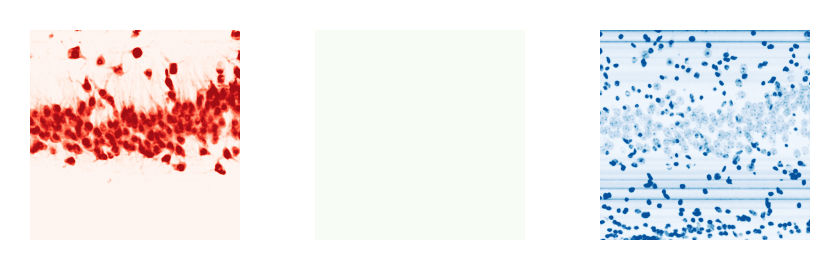

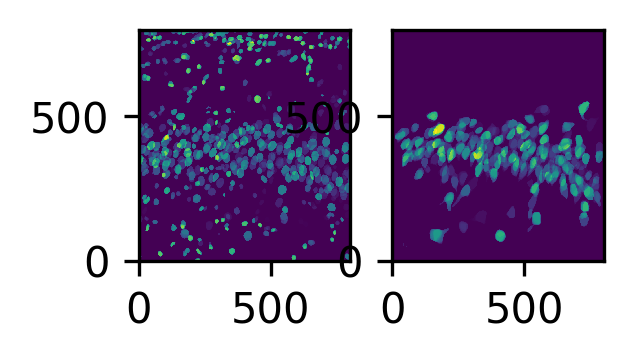

In [220]:
"""MAIN"""

# def qunatify_image_stack(tiff_loc):
# tiff_data_raw = tifffile.imread(curr_tif)
tiff_data = preprocess_image(tiff_data_raw)
rgb_stack = tiff_to_RGB_stack(tiff_data)
split_proj(rgb_stack)

nuclear_masks = fit_nuclear_model(rgb_stack,nuclear_channel=3)
results_dict = fit_cell_model(rgb_stack)
cell_masks = results_dict['cell_masks']
cell_masks, cell_masks_og = no_edges(cell_masks)

fig,ax = plt.subplots(1,2,figsize=(2,1),dpi=300)
ax[0].pcolorfast(np.sum(nuclear_masks,axis=0))
ax[1].pcolorfast(np.sum(cell_masks,axis=0))